(Re)extractions of the G140m MM spectra. Inspecting all of them except TRAPPIST-1 and GJ 699, which have already been done in detail.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interpolate
from craftroom import resample
import stistools
from astropy.convolution import convolve, Box1DKernel

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


In [40]:
path = '/home/david/work/muscles/SEDs/lya/'
dpath = path+'data/'
flts = glob.glob(dpath+'*flt.fits')
x1ds = glob.glob(dpath+'*x1d.fits')
raws = glob.glob(dpath+'*raw.fits')

In [38]:
print(len(flts))
print(len(x1ds))
print(len(raws))

20
21
23


In [41]:
froots =[]
xroots = []
rroots = []
for x, f, r in zip(x1ds, flts, raws):
    froots.append(fits.getheader(f)['ROOTNAME'])
    xroots.append(fits.getheader(x)['ROOTNAME'])
    rroots.append(fits.getheader(r)['ROOTNAME'])
for r in rroots:
    if r not in xroots:
        print (r, fits.getheader(dpath+r+'_raw.fits')['TARGNAME'])

odlm30040 LP-756-18
odlm30030 LP-756-18
odlm31030 LP-756-18


LP-756-18 is a non detection. GJ849 is incorrectly listed as having 0s exptime, I've already corrected it. Moving those files here- done!

In [42]:
stars = []
for x in x1ds:
    stars.append(fits.getheader(x)['TARGNAME'])
stars = np.unique(stars)
print(stars)

['GJ1132' 'GJ163' 'GJ649' 'GJ674' 'GJ676A' 'GJ849' 'L-980-5' 'LHS-2686'
 'LP-756-18']


GJ1132
odlm03040
odlm03050


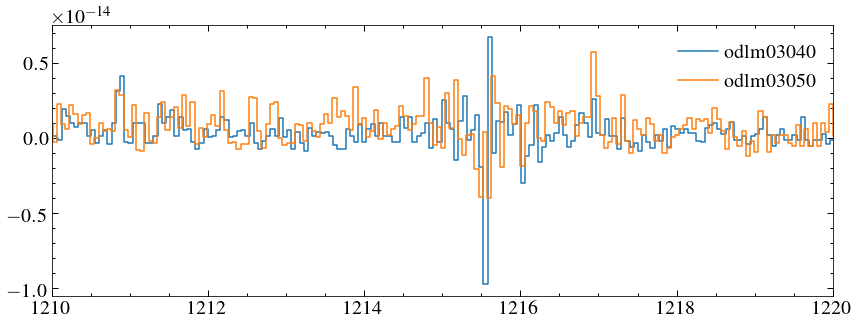

GJ163
odlm15050
odlm15040
odlm15030


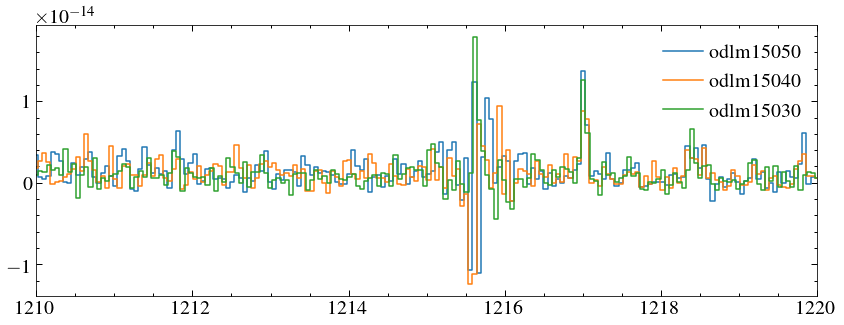

GJ649
odlm12030
odlm12040


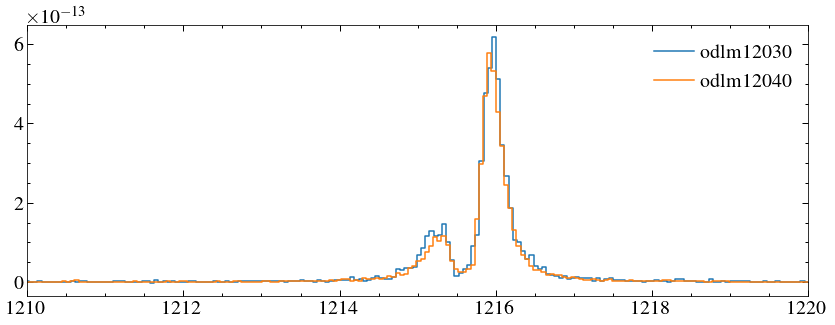

GJ674
odlm21030
odlm21040


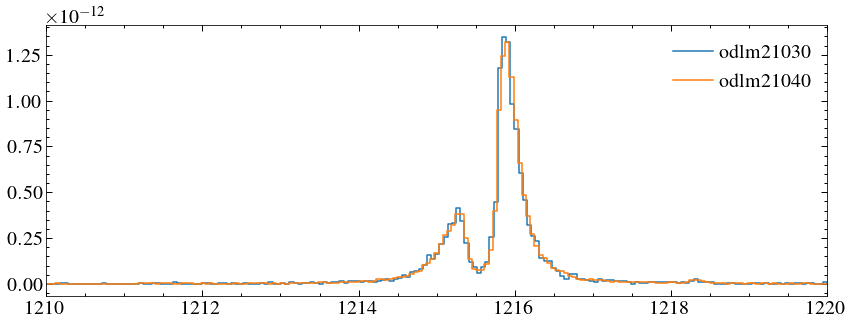

GJ676A
odlm06050
odlm06040


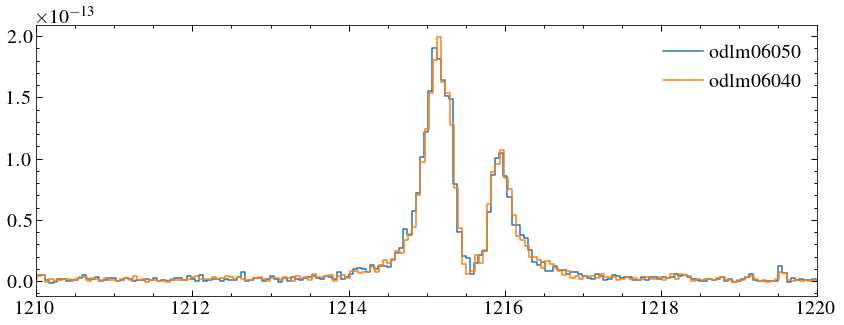

GJ849
odlm18030
odlm18040


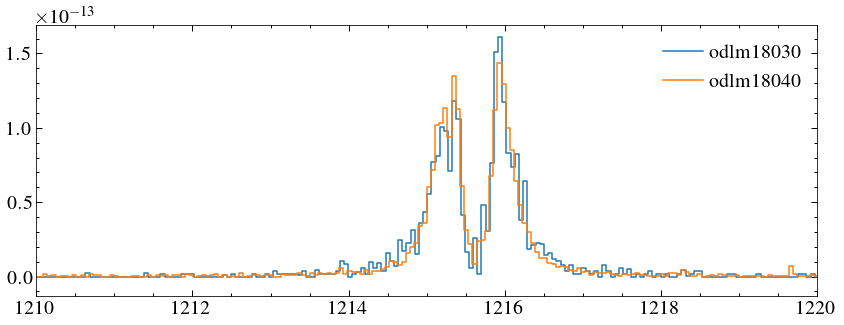

L-980-5
odlm27040
odlm27050


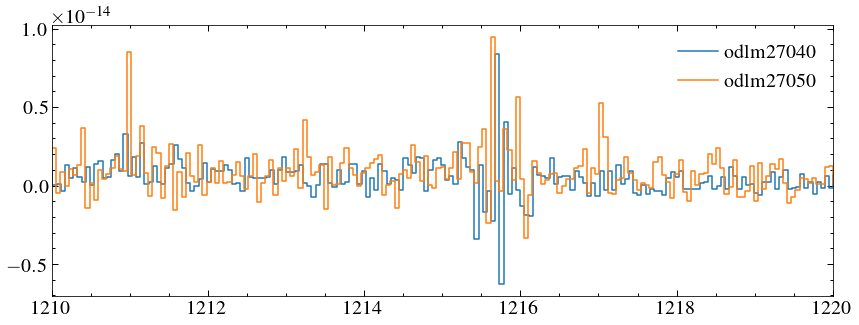

LHS-2686
odlm34030
odlm35040
odlm35030
odlm34040


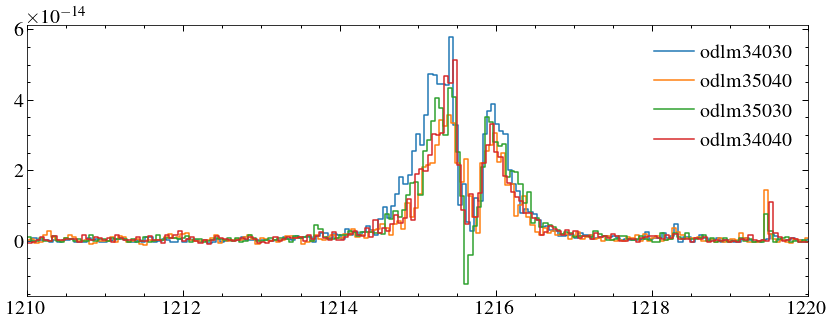

LP-756-18
odlm31040


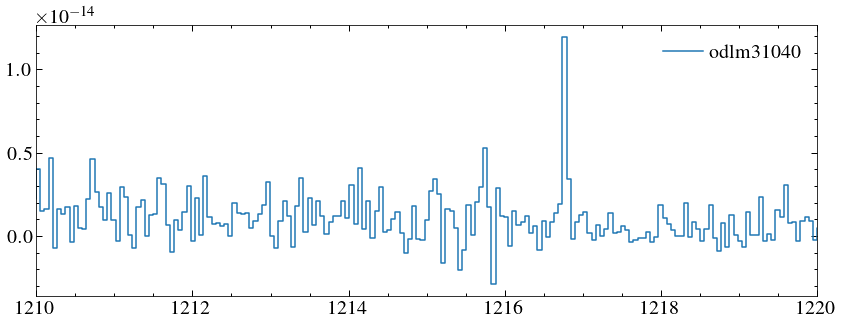

In [43]:
for star in stars:
    print(star)
    for x in x1ds:
        hdul = fits.open(x)
        if hdul[0].header['TARGNAME'] == star:
            data = hdul[1].data[0]
            rootname = hdul[0].header['ROOTNAME']
            print(rootname)
            plt.step(data['WAVELENGTH'], data['FLUX'], where='mid', label=rootname)
        hdul.close()
    plt.xlim(1210, 1220)
    plt.legend()
    plt.show()

GJ1132, GJ163, L-980-5 and 1xLHS-2686 need re-extracting. Have alread done LHS 2686? Maybe variable. Done, moved here. Ok, rextract those that need doing, then coadd.b 

Looked at flts, L-980-5 is maybe a non-detection. Firm detections in the others.

In [44]:
def build_trace_grid(SPTRCTAB, grating, cenwave):
    """
    Extends a grid of trace displacements to cover all y positions
    """
    data = fits.getdata(SPTRCTAB, 1)
    tracedata = data[(data['OPT_ELEM']==grating) & (data['CENWAVE'] == cenwave)]
    all_y = np.arange(len(tracedata[0]['A2DISPL']))
    grid = interpolate.interp1d(tracedata['A2CENTER'], tracedata['A2DISPL'], axis=0, fill_value='extrapolate')(all_y)
    tracegrid = [a+b for a, b in zip(grid, all_y)] 
    return tracegrid

def get_a2center(x, y, tracegrid):
    """
    get the trace a2center at a1center
    """
    xcol = np.array(tracegrid)[:,int(x)]
    xind = (np.abs(xcol - y)).argmin()
    a2center = xind + 1 #calstis is 1-indexed 
    return a2center

def no_zero_errors(flux, error):
    """
    Corrects instances where negative flux measurements have very small errors
    """
    e_new = error
    for i in range(len(error)):
        if flux[i] < 0.0 and error[i] < 0.1*abs(flux[i]):
            e_new[i] = abs(flux[i])
    return e_new

def new_coadd(f_array, e_array):
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum(((flux - f_array)**2) * weights, axis=0) / (len(f_array)-1)
    error = (var * rcs)**0.5
    return flux, error

In [45]:
oref="${CRDS_PATH}/references/hst/oref/"


In [1]:
centab = Table.read('lya_trace_centers.ecsv')
rdstars = ['GJ1132', 'GJ163', 'L-980-5']
outpath = path+'new_extractions/'
#o_roots = ['od3v02010', 'od3v03010', 'od3v01020', 'od3v01010']
for fl in glob.glob(outpath+'*.fits'):
    os.remove(fl)

for flt in flts: 
    hdr = fits.getheader(flt, 0)
    target = hdr['TARGNAME']
    if target in rdstars:
        rootname = hdr['ROOTNAME']
        SPTRCTAB = hdr['SPTRCTAB']
        grating = hdr['OPT_ELEM']
        cenwave = hdr['CENWAVE']
        tracegrid = build_trace_grid('/home/david/crds_cache/references/hst/oref/'+SPTRCTAB[5:], grating, cenwave)
        rootarg = np.argwhere(centab['ROOTNAME']==rootname)[0][0]
        x = centab['XCOL'][rootarg]
        y = centab['A2CENTER'][rootarg]
        a2center = get_a2center(x,y, tracegrid)#adjust measured a2 center to central point
        stistools.x1d.x1d(flt, output=outpath+rootname+'_new_x1d.fits', verbose=False, 
                          trailer='trl_files/'+rootname+'.trl',a2center=a2center,maxsrch=5)
        x = outpath+rootname+'_new_x1d.fits'
        data = fits.getdata(x, 1)[0]
        wi, fi, ei = data['WAVELENGTH'], data['FLUX'], data['ERROR']
        plt.step(wi, fi, where='mid')
        plt.step(wi, ei, where='mid')
        plt.xlim(1210, 1220)
        print(target, rootname)
        plt.show()
     



        
        

NameError: name 'Table' is not defined

In [80]:
cpath = path+'to_coadd/'
new_x1ds = glob.glob(cpath+'*x1d.fits')
opath = path+'coadds/'

cstars = []
for x in new_x1ds:
    cstars.append(fits.getheader(x)['TARGNAME'])
cstars = np.unique(cstars)
print(cstars)

['GJ1132' 'GJ163' 'GJ849' 'LHS-2686']


GJ1132


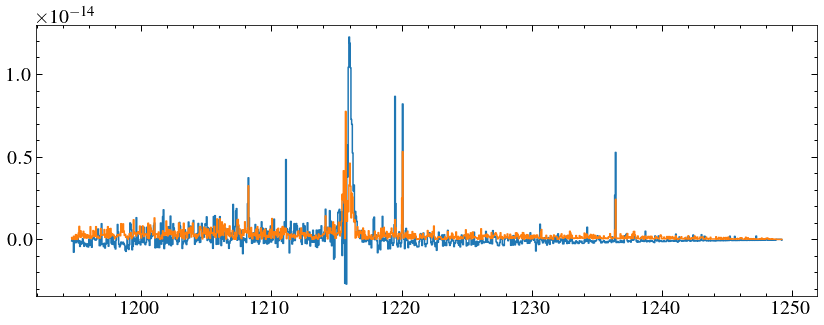

GJ163


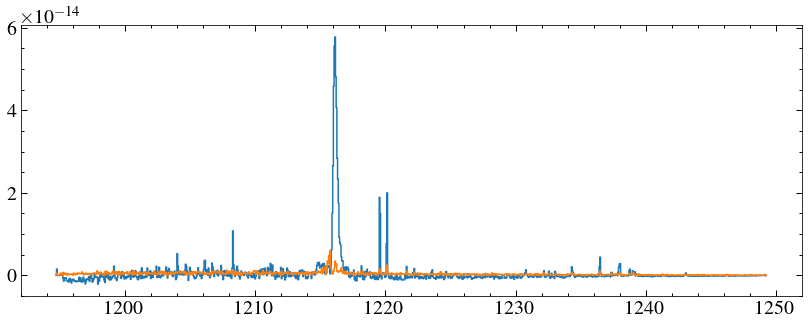

GJ849


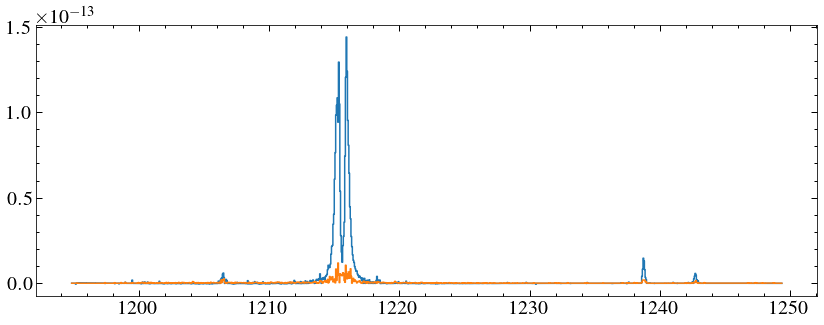

LHS-2686


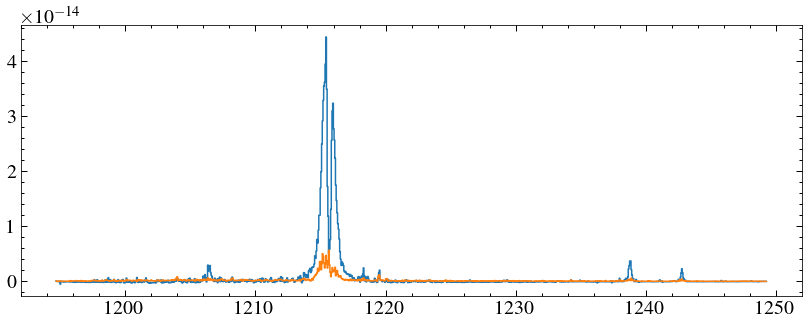

In [81]:
for star in cstars:
    fs = []
    es = []
    first = True
    for x in new_x1ds:
        hdul = fits.open(x)
        target = hdul[0].header['TARGNAME']
        rootname = hdul[0].header['ROOTNAME']
        if target == star:
                data = hdul[1].data[0]
                wi, fi, ei = data['WAVELENGTH'], data['FLUX'], data['ERROR']
                ei = no_zero_errors(fi, ei) 
                if star == 'LHS-2686':
                    savdat = Table((wi*u.AA, fi*u.erg/u.s/u.cm**2/u.AA, ei*u.erg/u.s/u.cm**2/u.AA), names=['WAVELENGTH', 'FLUX', 'ERROR'])
                    ascii.write(savdat, opath+star+'_g140m_'+rootname+'.ecsv', overwrite=True, format='ecsv')
                if  first:
                    w_new = wi
                    first = False
                else:
                    fi = interpolate.interp1d(wi, fi, fill_value='extrapolate')(w_new)
                    ei = interpolate.interp1d(wi, ei, fill_value='extrapolate')(w_new)
                fs.append(fi)
                es.append(ei)
        hdul.close()
    f_new, e_new = new_coadd(np.array(fs), np.array(es))
    plt.step(w_new, f_new, where='mid')
    plt.step(w_new, e_new, where='mid')
    print(star)
    plt.show()
    savdat = Table((w_new*u.AA, f_new*u.erg/u.s/u.cm**2/u.AA, e_new*u.erg/u.s/u.cm**2/u.AA), names=['WAVELENGTH', 'FLUX', 'ERROR'])
    ascii.write(savdat, opath+star+'_g140m_coadd_v1.ecsv', overwrite=True, format='ecsv')
    
                                                                

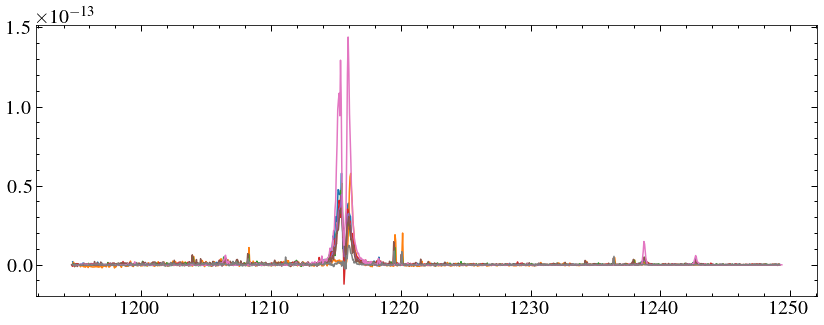

In [83]:
for sp in glob.glob(opath+'*ecsv'):
    dt = Table.read(sp)
    plt.plot(dt['WAVELENGTH'], dt['FLUX'])